In [1]:
!git clone https://github.com/zzh8829/yolov3-tf2
%cd yolov3-tf2/
!pip install -r requirements-gpu.txt

fatal: destination path 'yolov3-tf2' already exists and is not an empty directory.
/content/yolov3-tf2
Obtaining file:///content/yolov3-tf2 (from -r requirements-gpu.txt (line 6))
  Found existing installation: yolov3-tf2 0.1
    Can't uninstall 'yolov3-tf2'. No files were found to uninstall.
  Running setup.py develop for yolov3-tf2


In [2]:
%cd yolov3-tf2/
!ls

import tensorflow as tf
tf.__version__

[Errno 2] No such file or directory: 'yolov3-tf2/'
/content/yolov3-tf2
 checkpoints	   Icream_cycle.jpg   LICENSE
 colab_gpu.ipynb  'image1 (1).jpg'    README.md
 conda-cpu.yml	  'image1 (2).jpg'    requirements-gpu.txt
 conda-gpu.yml	  'image1 (3).jpg'    requirements.txt
 convert.py	   image1.jpg	      setup.py
 data		  'image2 (1).jpg'    tools
 detect.py	  'image2 (2).jpg'    train.py
 detect_video.py  'image2 (3).jpg'    yolov3_tf2
 docs		  'image2 (4).jpg'    yolov3_tf2.egg-info
 final_image.jpg   image2.jpg


'2.1.2'

In [3]:
!wget https://pjreddie.com/media/files/yolov3.weights -O data/yolov3.weights
!python convert.py

--2020-11-01 19:31:38--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘data/yolov3.weights’

data/yolov3.weights 100%[===================>] 236.52M   169KB/s    in 23m 58s 

2020-11-01 19:55:37 (168 KB/s) - ‘data/yolov3.weights’ saved [248007048/248007048]

2020-11-01 19:55:39.153643: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2020-11-01 19:55:39.153766: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object f

In [4]:
import time
from absl import app, flags, logging
from absl.flags import FLAGS
import cv2
import numpy as np
import tensorflow as tf
from yolov3_tf2.models import YoloV3
from yolov3_tf2.dataset import transform_images
from yolov3_tf2.utils import draw_outputs
import sys
from PIL import Image, ImageFile
import requests

# Flags are used to define several options for YOLO.
flags.DEFINE_string('classes', './data/coco.names', 'path to classes file')
flags.DEFINE_string('weights', './checkpoints/yolov3.tf',
                    'path to weights file')
flags.DEFINE_integer('size', 416, 'resize images to')
flags.DEFINE_integer('num_classes', 80, 'number of classes in the model')
FLAGS([sys.argv[0]])

# Locate devices to run YOLO on (e.g. GPU)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [5]:
yolo = YoloV3(classes=FLAGS.num_classes)
# Load weights and classes
yolo.load_weights(FLAGS.weights).expect_partial()
print('weights loaded')

class_names = [c.strip() for c in open(FLAGS.classes).readlines()]
print('classes loaded')

weights loaded
classes loaded


### Uploading Image from URL

In [ ]:
# Read image from github
url = "https://raw.githubusercontent.com/Rami-RK/"\
"Object_Captioning_YOLO/main/image1.jpg"
response = requests.get(url)
img_raw = tf.image.decode_image(response.content, channels=3).numpy()
#plt.imshow(img_raw)
display(Image.fromarray(img_raw, 'RGB'))

### Uploading image from local system

Saving bungy.jpg to bungy.jpg


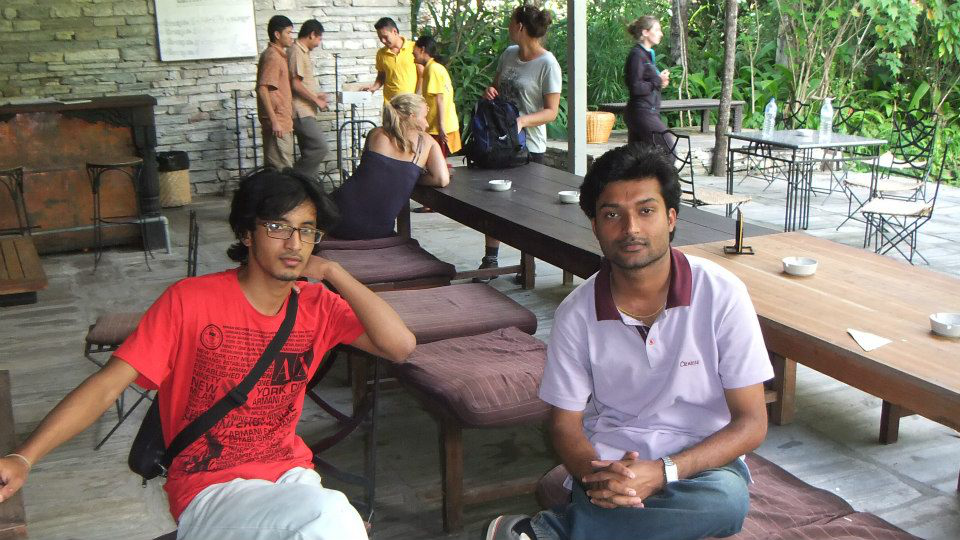

In [48]:
from google.colab import files
from PIL import Image
uploaded = files.upload()
path=list(uploaded.keys())[0]
image = Image.open(path)
img_raw=np.array(image)
display(Image.fromarray(img_raw, 'RGB')) # Display the image


In [39]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [49]:
# Preprocess image
img = tf.expand_dims(img_raw, 0)
img = transform_images(img, FLAGS.size)

# Desired threshold (any sub-image below this confidence 
# level will be ignored.)
FLAGS.yolo_score_threshold = 0.5

# Recognize and report results
t1 = time.time()
boxes, scores, classes, nums = yolo(img)
t2 = time.time()
print(f"Prediction time: {hms_string(t2 - t1)}")

Prediction time: 0:00:01.23


In [50]:
print('detections:')
for i in range(nums[0]):
    cls = class_names[int(classes[0][i])]
    score = np.array(scores[0][i])
    box = np.array(boxes[0][i])
    print(f"\t{cls}, {score}, {box}")

detections:
	person, 0.9930683970451355, [0.5160196 0.2129106 0.8148197 1.       ]
	person, 0.9877405762672424, [0.00697203 0.3153908  0.41104615 0.9892893 ]
	person, 0.9750338196754456, [0.50913256 0.01048899 0.58490187 0.32431147]
	chair, 0.9388623237609863, [0.89163625 0.33368576 0.97762203 0.48769897]
	person, 0.857845664024353, [0.28555402 0.03185241 0.3584024  0.37996697]
	backpack, 0.8554551601409912, [0.48516226 0.17635912 0.5491024  0.3075115 ]
	person, 0.8551767468452454, [0.33024383 0.17525916 0.48524213 0.5362848 ]
	person, 0.834090530872345, [0.42338848 0.05944806 0.4770019  0.29257062]
	person, 0.7966289520263672, [0.6467594  0.04411185 0.69939315 0.28657043]
	diningtable, 0.7224946022033691, [0.73501575 0.39697158 0.9991181  0.9110936 ]
	handbag, 0.6377133131027222, [0.1525303  0.5436126  0.33375698 0.8750067 ]
	diningtable, 0.5739165544509888, [0.40314776 0.30263516 0.64273995 0.51765454]


### Captioned Output

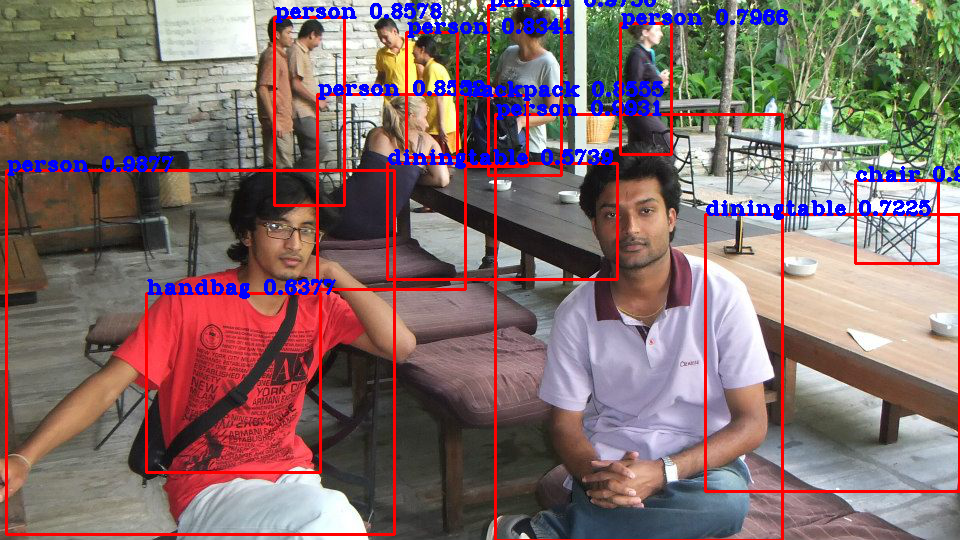

In [51]:
# Display image using YOLO library's built in function
img = draw_outputs(img_raw, (boxes, scores, classes, nums), class_names)
cv2.imwrite('final_image.jpg',img) # Save the image
display(Image.fromarray(img, 'RGB')) # Display the image




### Downloading the image


In [47]:
from google.colab import files
files.download( 'final_image.jpg' )    

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>